In [50]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [52]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, 
                       message="X does not have valid feature names*")

# Load Modeland Data

In [55]:
def load_data(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load all necessary data
X_train = load_data('X_train_data.pkl')
y_train_adhd = load_data('y_train_adhd_data.pkl')
gender_train = load_data('gender_train_data.pkl')
X_test = load_data('X_test_data.pkl')
y_test_adhd = load_data('y_test_adhd_data.pkl')
gender_test = load_data('gender_test_data.pkl')
feature_names = load_data('feature_names.pkl')

In [57]:
def load_model(filename):
    """Load the trained model from disk"""
    with open(filename, 'rb') as file:
        loaded_model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return loaded_model
adhd_model = load_model('adhd_rf_model.pkl')

Model loaded from adhd_rf_model.pkl


Significant features from the t-tes

# T-test Features

In [61]:
significant_features = [
    'ColorVision_CV_Score', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Prosocial', 'Barratt_Barratt_P1_Occ'
]
#these are the feature found during pre processing

# Balanced Data set

In [64]:
def gender_balanced(train_data, test_data, significant_features, approach="remove"):
    
    if approach == "remove":
        # I am simply removing the significant features, that creates bias in model
        train_balanced = train_data.drop(columns=significant_features)
        test_balanced = test_data.drop(columns=significant_features)
        print(f"Removed {len(significant_features)} gender-biased features")
        
   
    
    return train_balanced, test_balanced

# Model Training

In [67]:
def train_gender_specific_models(X_train_balanced, y_train, sex_train, X_test_balanced, y_test, sex_test, random_state=42):
  
    # Get indices for males and females
    male_train_indices = sex_train == 0
    female_train_indices = sex_train == 1
    
    male_test_indices = sex_test == 0
    female_test_indices = sex_test == 1
    
    # I wanted check if the features were removed or not
    print(f"Male training data shape: {X_train_balanced[male_train_indices].shape}")
    print(f"Female training data shape: {X_train_balanced[female_train_indices].shape}")
    print(f"Male test data shape: {X_test_balanced[male_test_indices].shape}")
    print(f"Female test data shape: {X_test_balanced[female_test_indices].shape}")
    
    # hyper parameter tuning, the parameters are the same as the initial model
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }
    
    
    base_male_model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    base_female_model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    
    # cross-validation 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Training model for males with hyperparameter tuning
    print("Training male-specific model with hyperparameter tuning...")
    male_search = RandomizedSearchCV(
        estimator=base_male_model,
        param_distributions=param_grid,
        n_iter=30,
        scoring='f1_weighted',
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    male_search.fit(X_train_balanced[male_train_indices], y_train[male_train_indices]) # fiting the model
    
    print(f"Best parameters for male model: {male_search.best_params_}")
    print(f"Best cross-validation score for male model: {male_search.best_score_:.4f}")
    
    # Training model for females with hyperparameter tuning
    print("Training female-specific model with hyperparameter tuning...")
    female_search = RandomizedSearchCV(
        estimator=base_female_model,
        param_distributions=param_grid,
        n_iter=30,
        scoring='f1_weighted',
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    female_search.fit(X_train_balanced[female_train_indices], y_train[female_train_indices])
    
    print(f"Best parameters for female model: {female_search.best_params_}")
    print(f"Best cross-validation score for female model: {female_search.best_score_:.4f}")
    
    # Get the best model parameteres
    male_model = male_search.best_estimator_
    female_model = female_search.best_estimator_
    
    # Evaluate on test set
    # Male model on male test data
    male_preds = male_model.predict(X_test_balanced[male_test_indices])
    male_accuracy = accuracy_score(y_test[male_test_indices], male_preds)
    male_f1 = f1_score(y_test[male_test_indices], male_preds, average='weighted')
    
    print(f"Male model accuracy on male test data: {male_accuracy:.4f}")
    print(f"Male model F1 score on male test data: {male_f1:.4f}")
    
    # Female model on female test data
    female_preds = female_model.predict(X_test_balanced[female_test_indices])
    female_accuracy = accuracy_score(y_test[female_test_indices], female_preds)
    female_f1 = f1_score(y_test[female_test_indices], female_preds, average='weighted')
    
    print(f"Female model accuracy on female test data: {female_accuracy:.4f}")
    print(f"Female model F1 score on female test data: {female_f1:.4f}")
    
    # Check cross-gender performance
    male_on_female = male_model.score(X_test_balanced[female_test_indices], y_test[female_test_indices])
    female_on_male = female_model.score(X_test_balanced[male_test_indices], y_test[male_test_indices])
    
    print(f"Male model accuracy on female test data: {male_on_female:.4f}")
    print(f"Female model accuracy on male test data: {female_on_male:.4f}")
    
    return male_model, female_model

In [69]:
print("Original dataset shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


print("\nCreating gender-balanced datasets by removing biased features...")
X_train_balanced, X_test_balanced = create_gender_balanced_features(
    X_train, X_test, significant_features, approach="remove"
)



print("\nTraining gender-specific models using balanced features with hyperparameter tuning...")
male_model, female_model = train_gender_specific_models(
    X_train_balanced, y_train_adhd, gender_train, 
    X_test_balanced, y_test_adhd, gender_test
)

Original dataset shapes:
X_train shape: (970, 623)
X_test shape: (243, 623)

Creating gender-balanced datasets by removing biased features...
Removed 8 gender-biased features

Training gender-specific models using balanced features with hyperparameter tuning...
Male training data shape: (637, 615)
Female training data shape: (333, 615)
Male test data shape: (160, 615)
Female test data shape: (83, 615)
Training male-specific model with hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for male model: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30, 'class_weight': None}
Best cross-validation score for male model: 0.7595
Training female-specific model with hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters for female model: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 

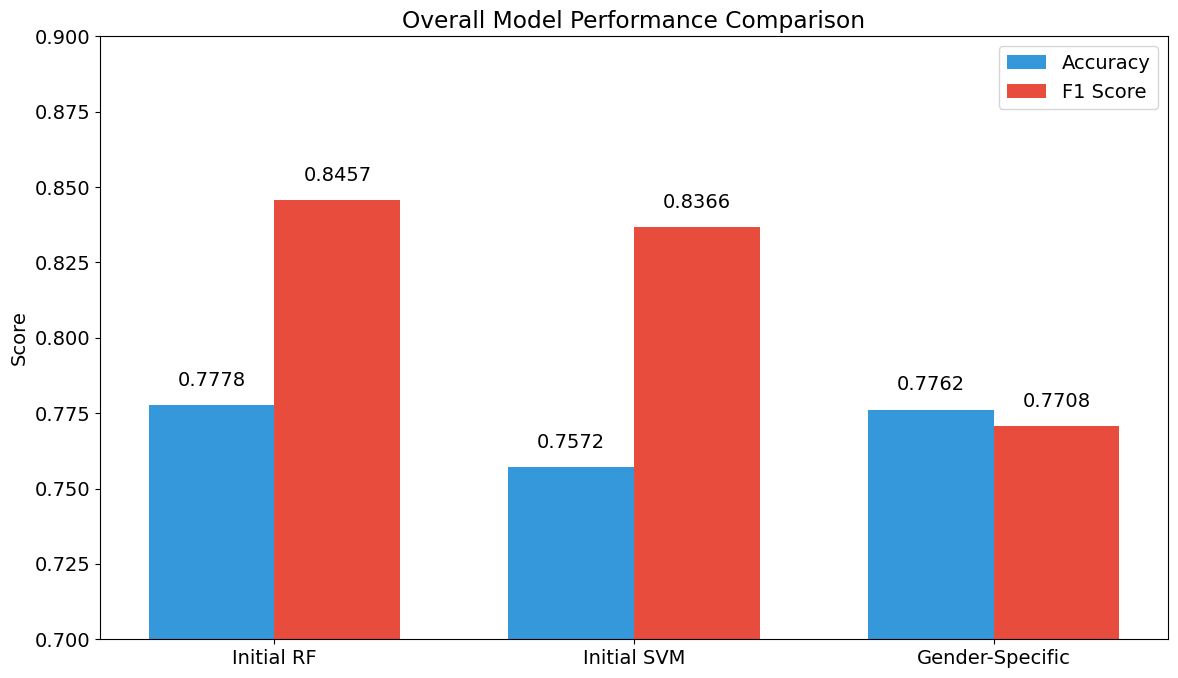

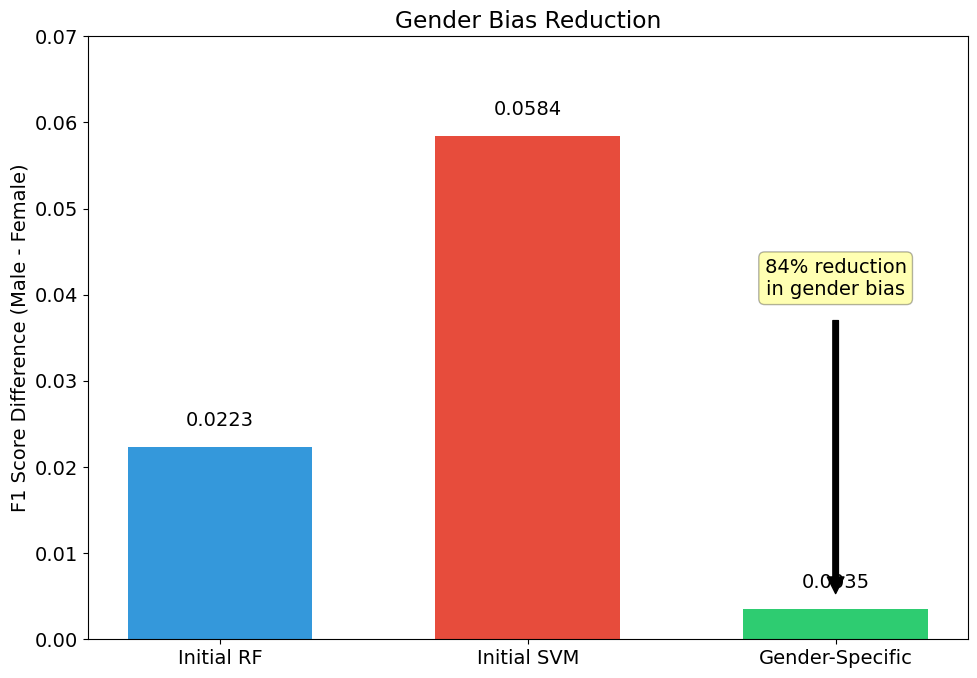

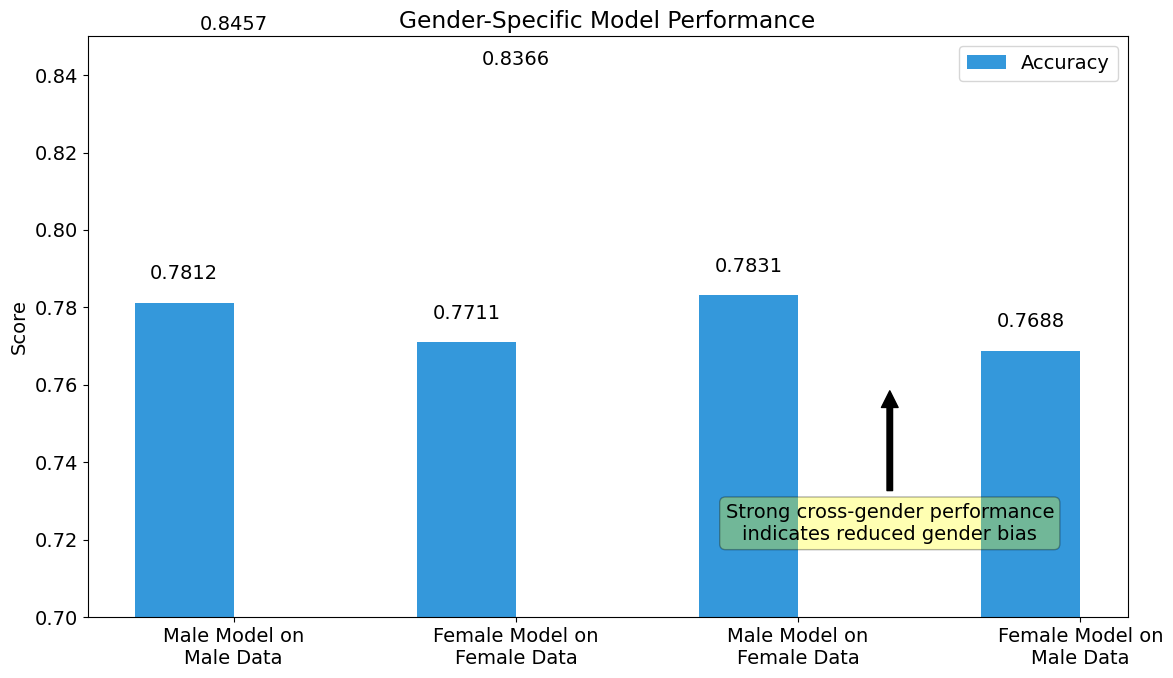

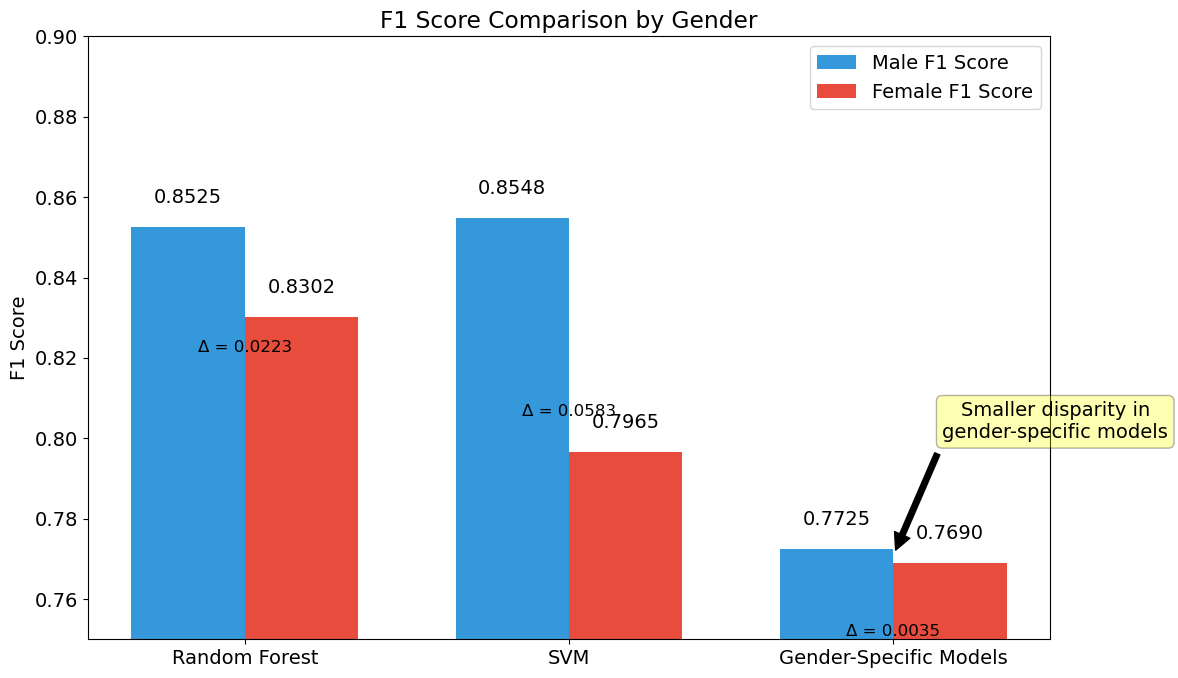

In [75]:



matplotlib.rcParams.update({'font.size': 14})

# Chart 1: Overall Performance Comparison
plt.figure(figsize=(12, 7))

# Data for the chart
models = ['Initial RF', 'Initial SVM', 'Gender-Specific']
accuracies = [0.7778, 0.7572, 0.7762]  # Average of male/female models for gender-specific
f1_scores = [0.8457, 0.8366, 0.7708]   # Average of male/female F1 scores

x = np.arange(len(models))
width = 0.35

# to create grouped bar chart
rects1 = plt.bar(x - width/2, accuracies, width, label='Accuracy', color='#3498db')
rects2 = plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='#e74c3c')


plt.ylabel('Score')
plt.title('Overall Model Performance Comparison')
plt.xticks(x, models)
plt.ylim(0.7, 0.9)
plt.legend()

# to add value labels on bars
for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom')
            
for rect in rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Chart 2: Gender Bias Reduction
plt.figure(figsize=(10, 7))

# Data for gender disparity
models = ['Initial RF', 'Initial SVM', 'Gender-Specific']
disparities = [0.0223, 0.0584, 0.0035]  # F1 score differences


bars = plt.bar(models, disparities, color=['#3498db', '#e74c3c', '#2ecc71'], width=0.6)


plt.ylabel('F1 Score Difference (Male - Female)')
plt.title('Gender Bias Reduction')
plt.ylim(0, 0.07)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
            f'{height:.4f}', ha='center', va='bottom')

# to add annotation highlighting the improvement, for ppt
plt.annotate('84% reduction\nin gender bias', 
            xy=(2, disparities[2]), 
            xytext=(2, 0.04),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', fontsize=14, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.tight_layout()
plt.show()

# Chart 3: Gender-Specific Performance
plt.figure(figsize=(12, 7))


categories = ['Male Model on\nMale Data', 'Female Model on\nFemale Data', 'Male Model on\nFemale Data', 'Female Model on\nMale Data']
accuracy_values = [0.7812, 0.7711, 0.7831, 0.7688]
f1_values = [0.7725, 0.7690, None, None]  

# Set up the plot
x = np.arange(len(categories))
width = 0.35

# Create bars for accuracy and F1 score where available
rects1 = plt.bar(x, accuracy_values, width, label='Accuracy', color='#3498db')







plt.ylabel('Score')
plt.title('Gender-Specific Model Performance')
plt.xticks(x + width/2, categories)
plt.ylim(0.7, 0.85)
plt.legend()


for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom')
            
for i, rect in enumerate(rects2):
    if f1_values[i] is not None:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom')


plt.annotate('Strong cross-gender performance\nindicates reduced gender bias', 
            xy=(2.5, 0.76), 
            xytext=(2.5, 0.72),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', fontsize=14, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 7))


models = ['Random Forest', 'SVM', 'Gender-Specific Models']
male_f1 = [0.8525, 0.8548, 0.7725]  
female_f1 = [0.8302, 0.7965, 0.7690]  

x = np.arange(len(models))
width = 0.35

# to create grouped bar chart
rects1 = plt.bar(x - width/2, male_f1, width, label='Male F1 Score', color='#3498db')
rects2 = plt.bar(x + width/2, female_f1, width, label='Female F1 Score', color='#e74c3c')


plt.ylabel('F1 Score')
plt.title('F1 Score Comparison by Gender')
plt.xticks(x, models)
plt.ylim(0.75, 0.9)
plt.legend()

# to add value labels on bars
for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom')
            
for rect in rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 0.005,
            f'{height:.4f}', ha='center', va='bottom')

# Adding annotations showing the disparity for ppt
for i in range(len(models)):
    disparity = male_f1[i] - female_f1[i]
    mid_point = (male_f1[i] + female_f1[i]) / 2
    plt.annotate(f'Δ = {disparity:.4f}', 
                xy=(i, mid_point),
                xytext=(i, mid_point - 0.02),
                ha='center', fontsize=12)

# Adding annotation highlighting the improvement for ppt
plt.annotate('Smaller disparity in\ngender-specific models', 
            xy=(2, (male_f1[2] + female_f1[2]) / 2), 
            xytext=(2.5, 0.8),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', fontsize=14, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

plt.tight_layout()

plt.show()







# LIME

In [86]:
def explain_with_lime(model, X_train, X_test, gender_test, feature_names):
    
    import lime
    import lime.lime_tabular
    import numpy as np
    import matplotlib.pyplot as plt
    
    # to convert pandas DataFrames to numpy arrays, to avoid error
    
    if hasattr(X_train, 'values'):
        X_train_array = X_train.values
    else:
        X_train_array = X_train
        
    if hasattr(X_test, 'values'):
        X_test_array = X_test.values
    else:
        X_test_array = X_test
    
    # Creating the LIME explainer
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_array,
        feature_names=feature_names,
        class_names=["Non-ADHD", "ADHD"],
        discretize_continuous=True
    )
    
    # Get explanation for a random test instance
    i = np.random.randint(0, X_test_array.shape[0])
    exp = explainer.explain_instance(X_test_array[i], model.predict_proba, num_features=10)
    
    # Ploting the explanation
    plt.figure(figsize=(10, 6))
    exp.as_pyplot_figure()
    plt.tight_layout()
    plt.show()
    
    # Check for gender-specific feature importance differences
    male_indices = np.where(gender_test == 0)[0]
    female_indices = np.where(gender_test == 1)[0]
    
    # Sample explanations for males and females
    male_samples = male_indices[:min(5, len(male_indices))]
    female_samples = female_indices[:min(5, len(female_indices))]
    
    male_exp = []
    for idx in male_samples:
        exp = explainer.explain_instance(X_test_array[idx], model.predict_proba, num_features=10)
        male_exp.append(exp)
    
    female_exp = []
    for idx in female_samples:
        exp = explainer.explain_instance(X_test_array[idx], model.predict_proba, num_features=10)
        female_exp.append(exp)
    
   
    print("Top features for male subjects:")
    for i, exp in enumerate(male_exp):
        print(f"Male sample {i+1}:")
        for feature, value in exp.as_list()[:5]: 
            print(f"  {feature}: {value:.4f}")
        print()
        
    print("\nTop features for female subjects:")
    for i, exp in enumerate(female_exp):
        print(f"Female sample {i+1}:")
        for feature, value in exp.as_list()[:5]:  #
            print(f"  {feature}: {value:.4f}")
        print()
    
    return male_exp, female_exp

<Figure size 1000x600 with 0 Axes>

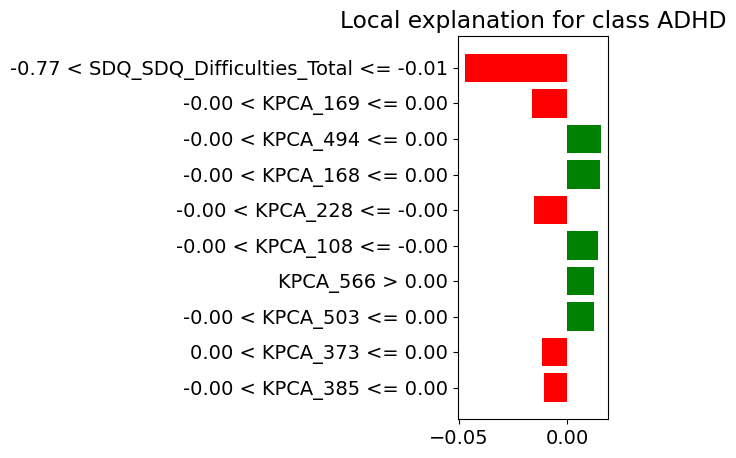

Top features for male subjects:
Male sample 1:
  -0.01 < SDQ_SDQ_Difficulties_Total <= 0.74: 0.1632
  0.00 < KPCA_183 <= 0.00: 0.0153
  0.00 < KPCA_8 <= 0.00: 0.0152
  -0.00 < KPCA_131 <= -0.00: 0.0145
  0.00 < KPCA_154 <= 0.00: -0.0135

Male sample 2:
  SDQ_SDQ_Difficulties_Total <= -0.77: -0.2893
  SDQ_SDQ_Generating_Impact <= -0.73: -0.0241
  -0.00 < KPCA_52 <= -0.00: 0.0132
  -0.00 < KPCA_552 <= 0.00: -0.0115
  -0.00 < KPCA_270 <= 0.00: -0.0091

Male sample 3:
  SDQ_SDQ_Difficulties_Total <= -0.77: -0.2873
  SDQ_SDQ_Generating_Impact <= -0.73: -0.0239
  0.00 < KPCA_513 <= 0.00: -0.0117
  0.00 < KPCA_584 <= 0.00: -0.0106
  0.00 < KPCA_8 <= 0.00: 0.0103

Male sample 4:
  -0.77 < SDQ_SDQ_Difficulties_Total <= -0.01: -0.0485
  -0.00 < KPCA_75 <= 0.00: 0.0168
  0.00 < KPCA_333 <= 0.00: 0.0151
  -0.00 < KPCA_142 <= 0.00: -0.0147
  -0.00 < KPCA_218 <= 0.00: 0.0146

Male sample 5:
  SDQ_SDQ_Difficulties_Total > 0.74: 0.2155
  -0.00 < KPCA_8 <= 0.00: 0.0193
  -0.02 < SDQ_SDQ_Generating_Impa

In [88]:
overall_lime_exps = explain_with_lime(
    model=adhd_model,  
    X_train=X_train,
    X_test=X_test,
    gender_test=gender_test,  
    feature_names=feature_names 
)

# Feature Importance

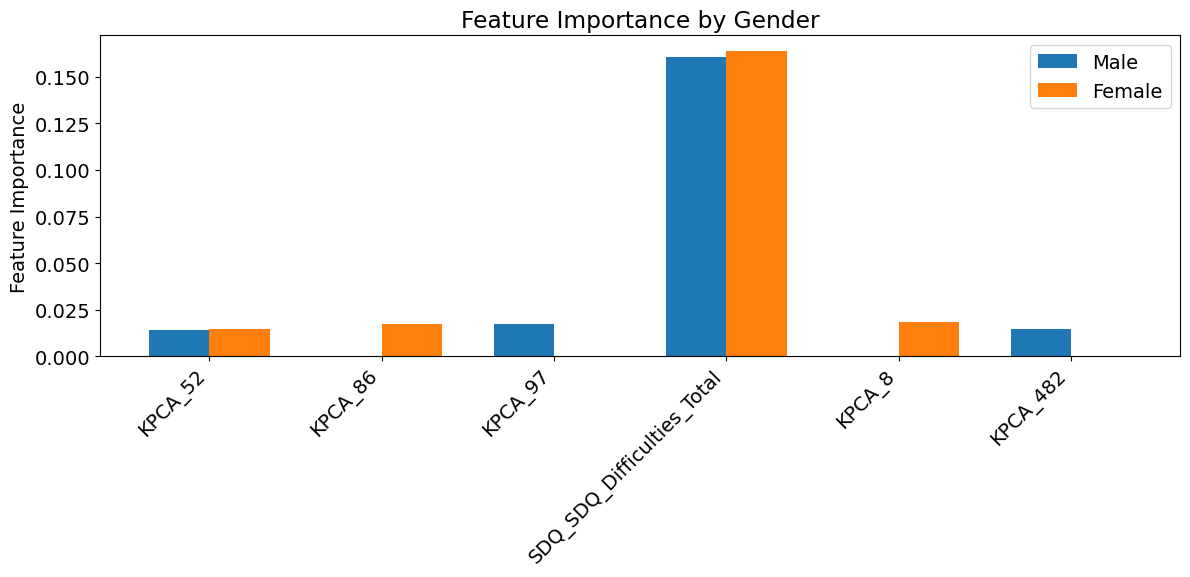

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# top features from LIME results
male_features = {
    'SDQ_SDQ_Difficulties_Total': 0.1607,
    'KPCA_97': 0.0172,
    'KPCA_482': 0.0148,
    'KPCA_52': 0.0140,
    'SDQ_SDQ_Generating_Impact': 0.0164
}

female_features = {
    'SDQ_SDQ_Difficulties_Total': 0.1639,
    'SDQ_SDQ_Generating_Impact': 0.0226,
    'KPCA_8': 0.0182,
    'KPCA_86': 0.0172,
    'KPCA_52': 0.0146
}


all_features = set(list(male_features.keys()) + list(female_features.keys()))
top_features = list(all_features)[:6]


male_values = [male_features.get(f, 0) for f in top_features]
female_values = [female_features.get(f, 0) for f in top_features]


x = np.arange(len(top_features))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, male_values, width, label='Male')
rects2 = ax.bar(x + width/2, female_values, width, label='Female')

ax.set_ylabel('Feature Importance')
ax.set_title('Feature Importance by Gender')
ax.set_xticks(x)
ax.set_xticklabels(top_features, rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.show()